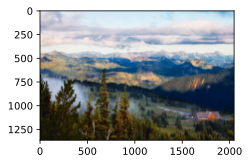

In [1]:
# 样式迁移
from d2l import torch as d2l
from torch import nn
import torchvision
import torch
%matplotlib inline

"""
    过程：训练一张图片X，输入为一张原图A，风格图片B
    对于一个模型参数不变，A，B不变，
    要使得在模型中某一些层 X提取出的特征 与 风格图片B提取出的特征 风格损失小
    在另一些层 X提取出的特征 与 原图A提取出的特征 内容损失小
    同时还要保证 `噪点损失` 要小

    在训练大图片的时候，可以使用如下的操作：
        1. 先截取部分图片进行训练
        2. 将训练好的权重进行放大，训练原始的大图片
"""

d2l.set_figsize()
content_img = d2l.Image.open('../data/rainier.jpg')
d2l.plt.imshow(content_img)


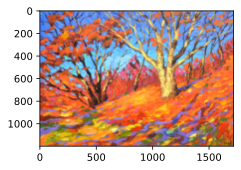

In [2]:
style_img = d2l.Image.open('../data/autumn-oak.jpg')
d2l.plt.imshow(style_img)


In [3]:
# 使用ImageNet上的正则化（因为要使用预训练模型）
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])


# 把图片变成tensor
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

# 把tensor变回图片
def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))


In [5]:
# 使用VGG19进行特征抽取（沐神说VGG19在抽取特征方面效果还可以）
pretrained_net = torchvision.models.vgg19(pretrained=True)

# 0, 5, 10, 19, 28用于匹配样式，25用于匹配内容
# 样式有下面和上面的层，因为既想匹配局部信息又想匹配全局信息
# 内容上不需要完全还原成原图，可以有一定变形，所以选了比较后面的
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

net = nn.Sequential(
    *[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)]
)


def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles


# 由于内容图片和样式图片以及VGG的权重都不变，因此可以预处理，这样只需要计算一次
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y


def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y


In [6]:
# 内容损失
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

# 样式损失：每个通道中像素的统计信息和通道之间的统计信息 =》 样式
#           即统计分布差不多是相同的
# 这边用了gram矩阵进行匹配
# 可以去学一下 一阶、二阶、三阶……统计信息公式
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

# 比较gram矩阵的均方误差
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

# 每个像素和周围像素的绝对值，控制噪点（降噪）
def tv_loss(Y_hat):
    return 0.5 * (
        torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
        torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean()
    )


In [8]:
content_weight, style_weight, tv_weight = 1, 1e4, 10


def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [
        content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)
    ]
    styles_l = [
        style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)
    ]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l


In [9]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight


def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer


In [10]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(
        xlabel='epoch', ylabel='loss',
        xlim=[10, num_epochs],
        legend=['content', 'style', 'TV'],
        ncols=2, 
        figsize=(7, 2.5)
    )
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features( # 对图片抽取特征
            X, content_layers, style_layers
        )
        contents_l, styles_l, tv_l, l = compute_loss( # 计算损失
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram
        )
        l.backward() # 反向传播，再更新
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(
                epoch + 1, 
                [
                    float(sum(contents_l)),
                    float(sum(styles_l)), 
                    float(tv_l)
                ]
            )
    return X


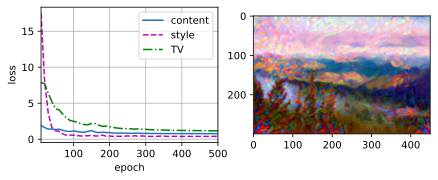

In [11]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)
